In [9]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch
import pickle

## Load Dataset

In [ ]:
# load dataset
train_df = pd.read_csv('dataset/train.csv')
val_df = pd.read_csv('dataset/val.csv')
test_df = pd.read_csv('dataset/test.csv')

In [12]:
parameters = pickle.load(open("dataset/dataset_parameters.pkl", "rb"))
feature_col = parameters["feature_cols"]
window_size = parameters["window_size"]
stride = parameters["stride"]

In [13]:
train_ds = InverterTimeSeriesDataset.from_dataframe(train_df, feature_col, window_size=window_size, stride=normal_stride)
val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   feature_col, window_size=window_size, stride=normal_stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  feature_col, window_size=window_size, stride=normal_stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 76.36it/s]


In [15]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)

## Load Model

In [ ]:
# load model
model = CNNLSTMModel(num_features=train_df.shape[1]-3, lstm_layers=2)
model.load_state_dict(torch.load(r'model\best_model_whole.pth'))
model.eval()

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(21, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.3)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
# === 2. Platt scaling (logistic regression) ===
platt = pickle.load(open("model/platt_scaler.pkl", "rb"))

## Evaluation

In [25]:
train_trues, train_outputs, train_loss= test_loop(model, train_loader)
val_trues, val_outputs, val_loss = test_loop(model, val_loader)
test_trues, test_outputs, test_loss = test_loop(model, test_loader)

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Testing: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


In [ ]:
from sklearn.linear_model import LogisticRegression
from src.train import get_logits_and_labels

val_logits, val_labels = get_logits_and_labels(model, val_loader)
test_logits, test_labels = get_logits_and_labels(model, test_loader)

val_probs_calibrated = platt.predict_proba(val_logits.reshape(-1, 1))[:, 1]
test_probs_calibrated = platt.predict_proba(test_logits.reshape(-1, 1))[:, 1]

threshold = 0.5
test_preds = (test_probs_calibrated >= threshold).astype(int)
val_preds = (val_probs_calibrated >= threshold).astype(int)

In [ ]:
import plotly.express as px

def plot_output_distribution(probs_calibrated, labels, title="Validation Outputs Distribution"):
    df = pd.DataFrame(
        {
            "scores": probs_calibrated,
            "labels": labels
        }
    )
    fig = px.histogram(df, x="scores", color="labels", barmode="stack", histnorm="probability", title=title)
    fig.show()


### Validation Set

Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       1.00      0.87      0.93     11210
     Failure       0.04      1.00      0.08        60

    accuracy                           0.87     11270
   macro avg       0.52      0.93      0.50     11270
weighted avg       0.99      0.87      0.93     11270

[[9741 1469]
 [   0   60]]
ROC AUC: 0.9535


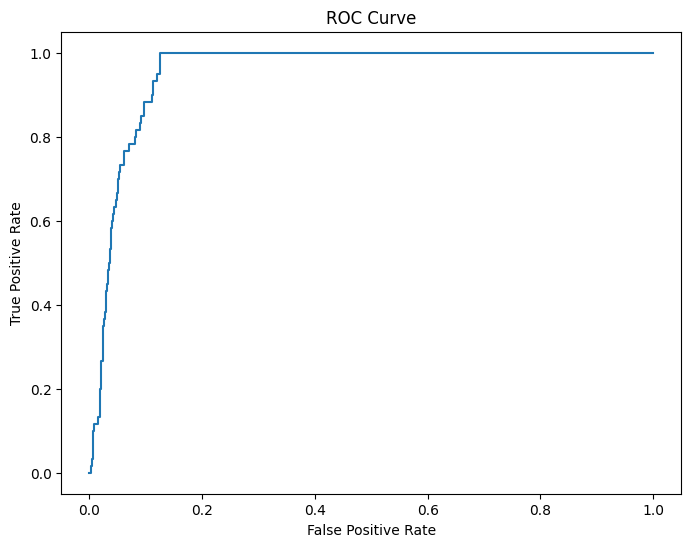

In [28]:
print("Performance on Validation Set:")
generate_report(val_labels, val_preds, val_probs_calibrated,)

In [ ]:
plot_output_distribution(val_logits, val_labels, title="Validation Logits Distribution")
plot_output_distribution(torch.sigmoid(torch.tensor(val_logits)).numpy(), val_labels, title="Validation Scores Distribution")
plot_output_distribution(val_probs_calibrated, val_labels, title="Validation Outputs Distribution")

### Test Set

Performance on Test Set:
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96     10919
     Failure       0.02      0.27      0.03        60

    accuracy                           0.92     10979
   macro avg       0.51      0.59      0.50     10979
weighted avg       0.99      0.92      0.95     10979

[[10047   872]
 [   44    16]]
ROC AUC: 0.7133


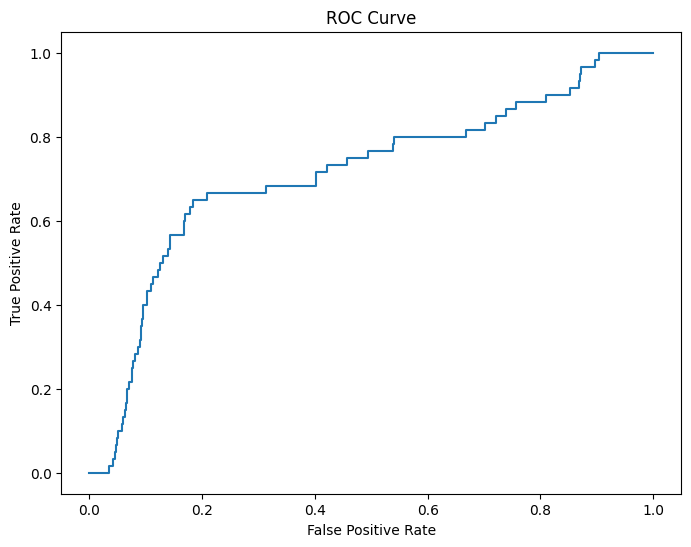

In [29]:
print("Performance on Test Set:")
generate_report(test_labels, test_preds, test_probs_calibrated)

In [30]:
plot_output_distribution(test_logits, test_labels, title="Test Logits Distribution")
plot_output_distribution(torch.sigmoid(torch.tensor(test_logits)).numpy(), test_labels, title="Test Scores Distribution")
plot_output_distribution(test_probs_calibrated, test_labels, title="Test Outputs Distribution")